# Анализ потребления алкоголя школьниками

Анализ данных из датасета [Student Alcohol Consumption](https://www.kaggle.com/datasets/uciml/student-alcohol-consumption). Цель анализа — понять факторы, влияющие на потребление алкоголя студентами, сегментировать студентов и построить модели для прогнозирования уровня потребления алкоголя.


In [1340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

Датасет содержит две части: `student-mat.csv` и `student-por.csv`, соответствующие студентам, изучающим математику и португальский язык соответственно. Мы объединим эти два набора данных для более полного анализа.

In [1341]:
mat_data = pd.read_csv('student-mat.csv')
por_data = pd.read_csv('student-por.csv')

print(f"Количество студентов, посещающих математику: {mat_data.shape}")
print(f"Количество студентов, посещающих португальский: {por_data.shape}")

Количество студентов, посещающих математику: (395, 33)
Количество студентов, посещающих португальский: (649, 33)


In [1342]:
# Объединение данных
common_columns = list(set(mat_data.columns).intersection(set(por_data.columns)))

data = pd.concat([mat_data[common_columns], por_data[common_columns]], axis=0, ignore_index=True)
print(f"Объединенный размер данных: {data.shape}")

Объединенный размер данных: (1044, 33)


In [1343]:
data.head()

,goout,address,higher,age,romantic,G1,activities,school,freetime,nursery,...,Dalc,Fedu,failures,schoolsup,famsup,health,guardian,G3,internet,traveltime
0,4,U,yes,18,no,5,no,GP,3,yes,...,1,4,0,yes,no,3,mother,6,no,2
1,3,U,yes,17,no,5,no,GP,3,no,...,1,1,0,no,yes,3,father,6,yes,1
2,2,U,yes,15,no,7,no,GP,3,yes,...,2,1,3,yes,no,3,mother,10,yes,1
3,2,U,yes,15,yes,15,yes,GP,2,yes,...,1,2,0,no,yes,5,mother,15,yes,1
4,2,U,yes,16,no,6,no,GP,3,yes,...,1,3,0,no,yes,5,father,10,no,1


In [1344]:
# Проверка на наличие пропущенных значений
data.isnull().sum()

goout         0
address       0
higher        0
age           0
romantic      0
G1            0
activities    0
school        0
freetime      0
nursery       0
absences      0
Mjob          0
reason        0
studytime     0
G2            0
Medu          0
famrel        0
sex           0
famsize       0
Pstatus       0
paid          0
Walc          0
Fjob          0
Dalc          0
Fedu          0
failures      0
schoolsup     0
famsup        0
health        0
guardian      0
G3            0
internet      0
traveltime    0
dtype: int64

Предварительный анализ данных (EDA)

В данном разделе мы исследуем распределение признаков, их взаимосвязи и основные статистические характеристики.

In [1345]:
# Основные статистические характеристики
data.describe()

,goout,age,G1,freetime,absences,studytime,G2,Medu,famrel,Walc,Dalc,Fedu,failures,health,G3,traveltime
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,3.156130,16.726054,11.213602,3.201149,4.434866,1.970307,11.246169,2.603448,3.935824,2.284483,1.494253,2.387931,0.264368,3.543103,11.341954,1.522989
std,1.152575,1.239975,2.983394,1.031507,6.210017,0.834353,3.285071,1.124907,0.933401,1.285105,0.911714,1.099938,0.656142,1.424703,3.864796,0.731727
min,1.000000,15.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,2.000000,16.000000,9.000000,3.000000,0.000000,1.000000,9.000000,2.000000,4.000000,1.000000,1.000000,1.000000,0.000000,3.000000,10.000000,1.000000
50%,3.000000,17.000000,11.000000,3.000000,2.000000,2.000000,11.000000,3.000000,4.000000,2.000000,1.000000,2.000000,0.000000,4.000000,11.000000,1.000000
75%,4.000000,18.000000,13.000000,4.000000,6.000000,2.000000,13.000000,4.000000,5.000000,3.000000,2.000000,3.000000,0.000000,5.000000,14.000000,2.000000
max,5.000000,22.000000,19.000000,5.000000,75.000000,4.000000,19.000000,4.000000,5.000000,5.000000,5.000000,4.000000,3.000000,5.000000,20.000000,4.000000


<Figure size 1200x500 with 0 Axes>

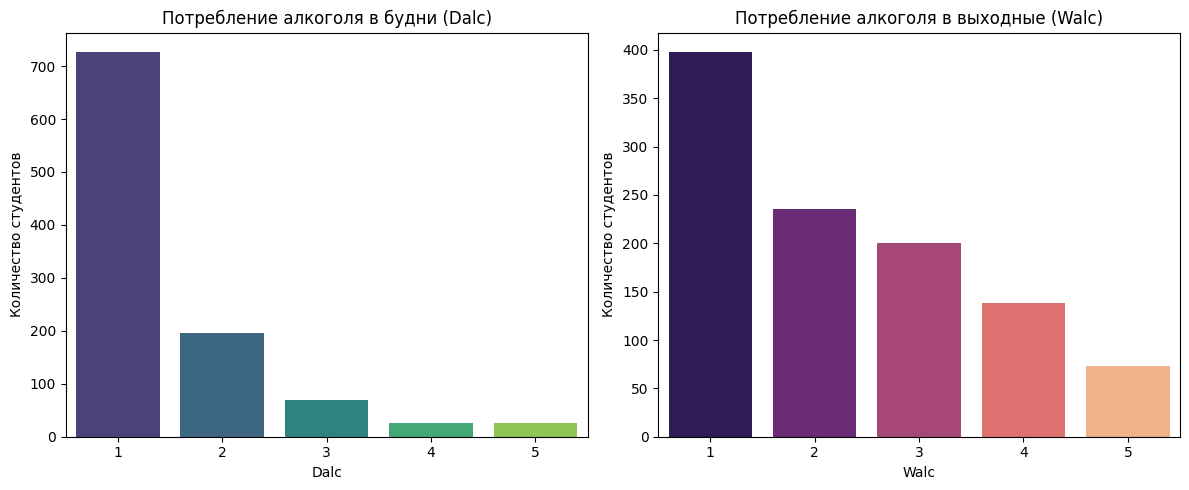

In [1346]:
# Распределение потребления алкоголя (Dalc и Walc)
plt.figure(figsize=(12,5))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.countplot(x='Dalc', data=data, palette='viridis')
plt.title('Потребление алкоголя в будни (Dalc)')
plt.xlabel('Dalc')
plt.ylabel('Количество студентов')

plt.subplot(1,2,2)
sns.countplot(x='Walc', data=data, palette='magma')
plt.title('Потребление алкоголя в выходные (Walc)')
plt.xlabel('Walc')
plt.ylabel('Количество студентов')

plt.tight_layout()
plt.show()

Видно, что по выходным больше пьют

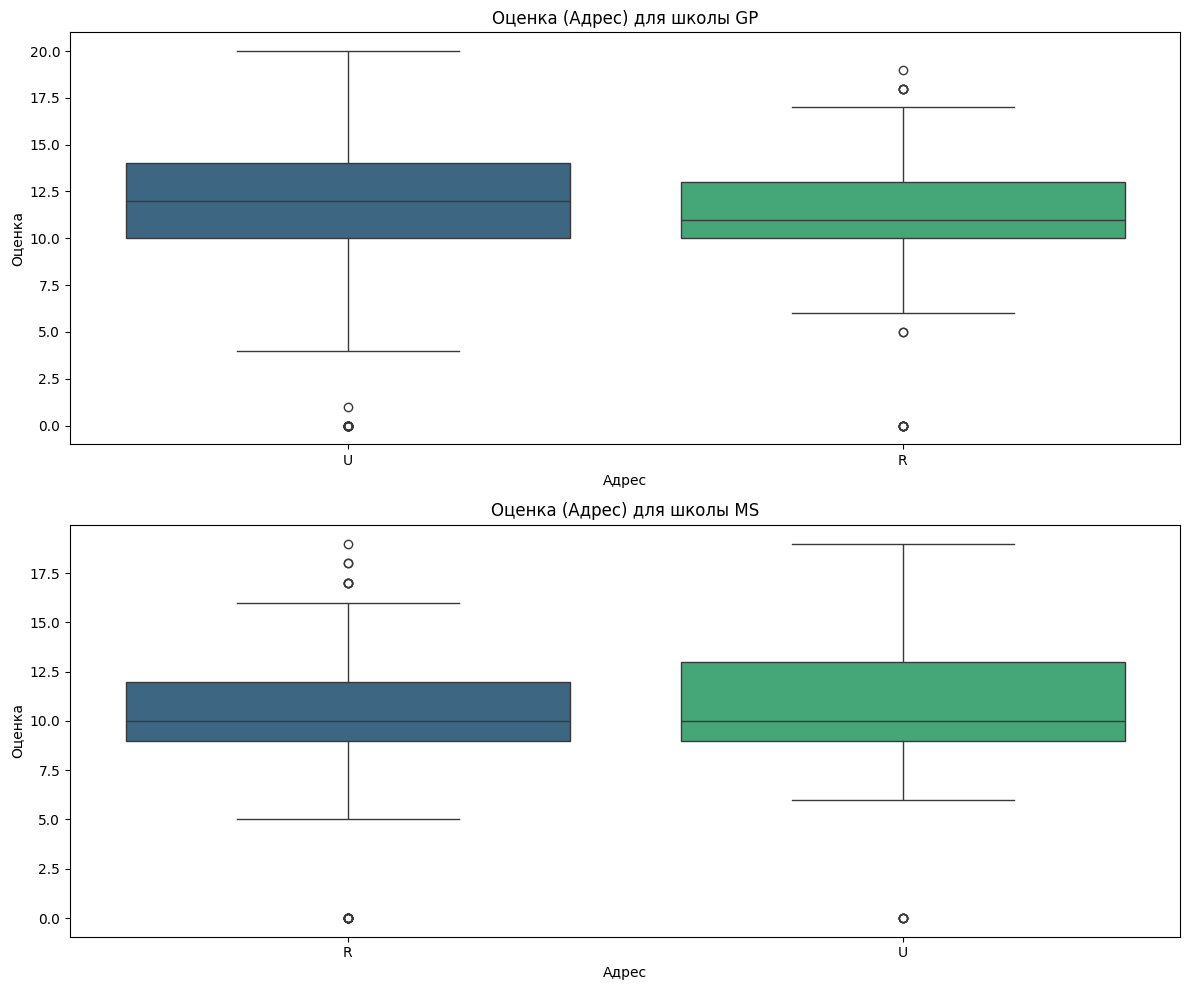

In [1347]:
# Зависимость оценки от места проживания
schools = data['school'].unique()

plt.figure(figsize=(12, 5 * len(schools)))

for i, school in enumerate(schools):
    plt.subplot(len(schools), 1, i + 1)
    sns.boxplot(x='address', y='G3', data=data[data['school'] == school], palette='viridis')
    plt.title(f'Оценка (Адрес) для школы {school}')
    plt.xlabel('Адрес')
    plt.ylabel('Оценка')

plt.tight_layout()
plt.show()

Те, кто живёт в городе, в среднем получают выше оценку

Text(0.5, 1.0, 'Distribution of grades for students who does not want to get higher education')

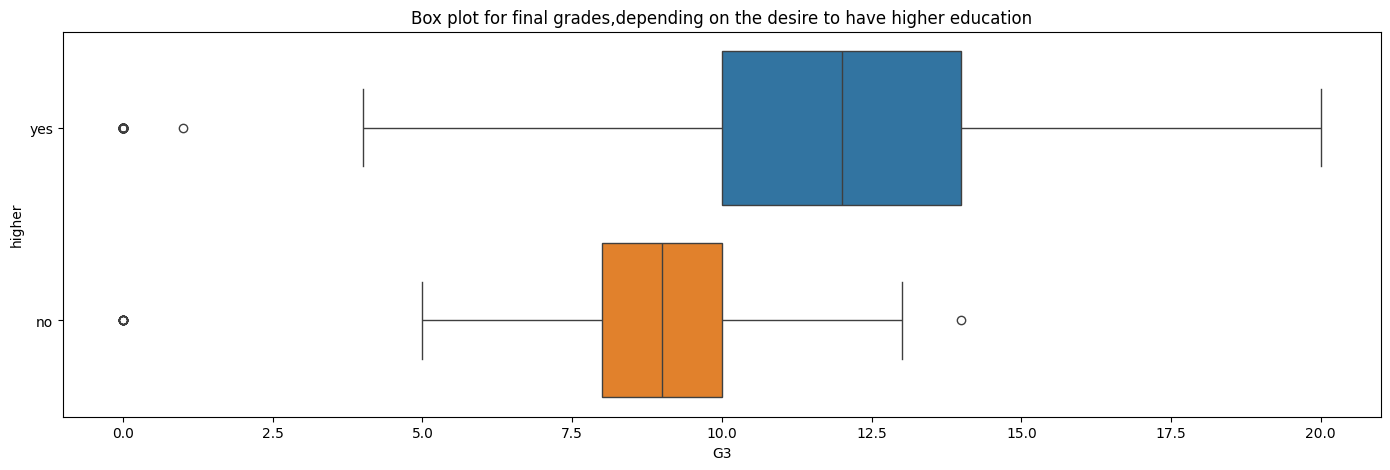

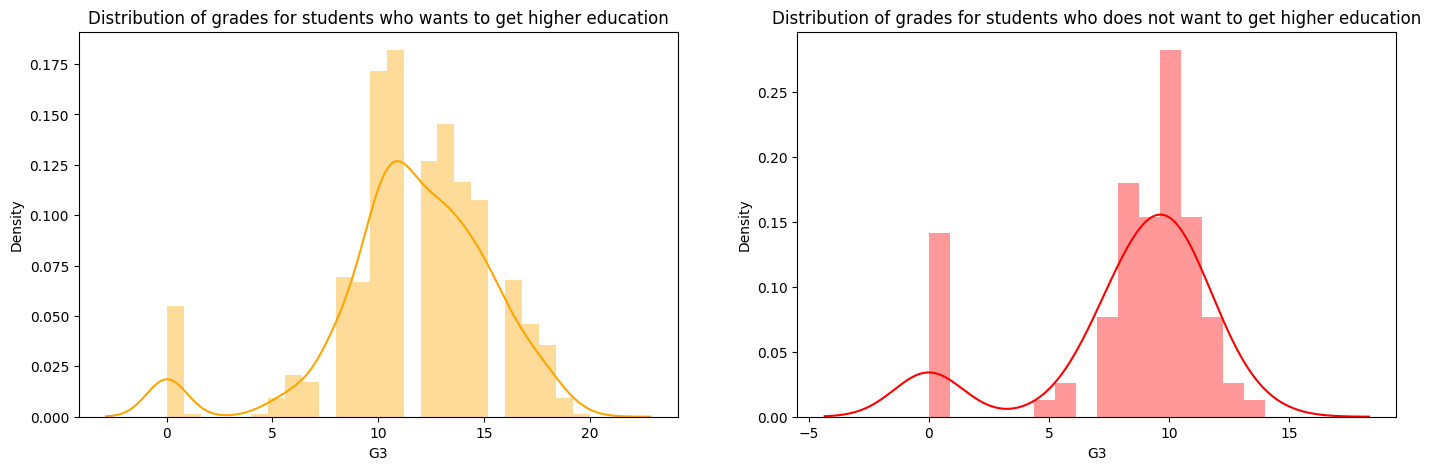

In [1348]:
plt.figure(figsize=(17,5))
plt.title("Box plot for final grades,depending on the desire to have higher education")
sns.boxplot(y="higher", x="G3", data = data , orient="h", palette = 'tab10')

f= plt.figure(figsize=(17,5))
ax=f.add_subplot(121)
sns.distplot(data[(data.higher == 'yes')]["G3"],color='orange',ax=ax)
ax.set_title('Distribution of grades for students who wants to get higher education')

ax=f.add_subplot(122)
sns.distplot(data[(data.higher == 'no')]['G3'],color='red',ax=ax)
ax.set_title('Distribution of grades for students who does not want to get higher education')

Кто хочет получить высшее образование - лучше учится

In [1349]:
# Кодирование категориальных признаков
categorical_columns = data.select_dtypes(include=['object']).columns
data_encoded_eda = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

corr = data_encoded_eda.corr()

In [1350]:
def cor_with_threshold(corr_matrix, threshold):
    corr_no_diag = corr_matrix.copy()
    np.fill_diagonal(corr_no_diag.values, 0)
    high_corr_var = corr_no_diag.columns[(corr_no_diag.abs() > threshold).any()]
    filtered_corr = corr_matrix.loc[high_corr_var, high_corr_var]
    plt.figure(figsize=(20,15))
    sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, linecolor="black")
    plt.title(f"Корреляционная матрица (значения |corr| > {threshold})")
    plt.show()

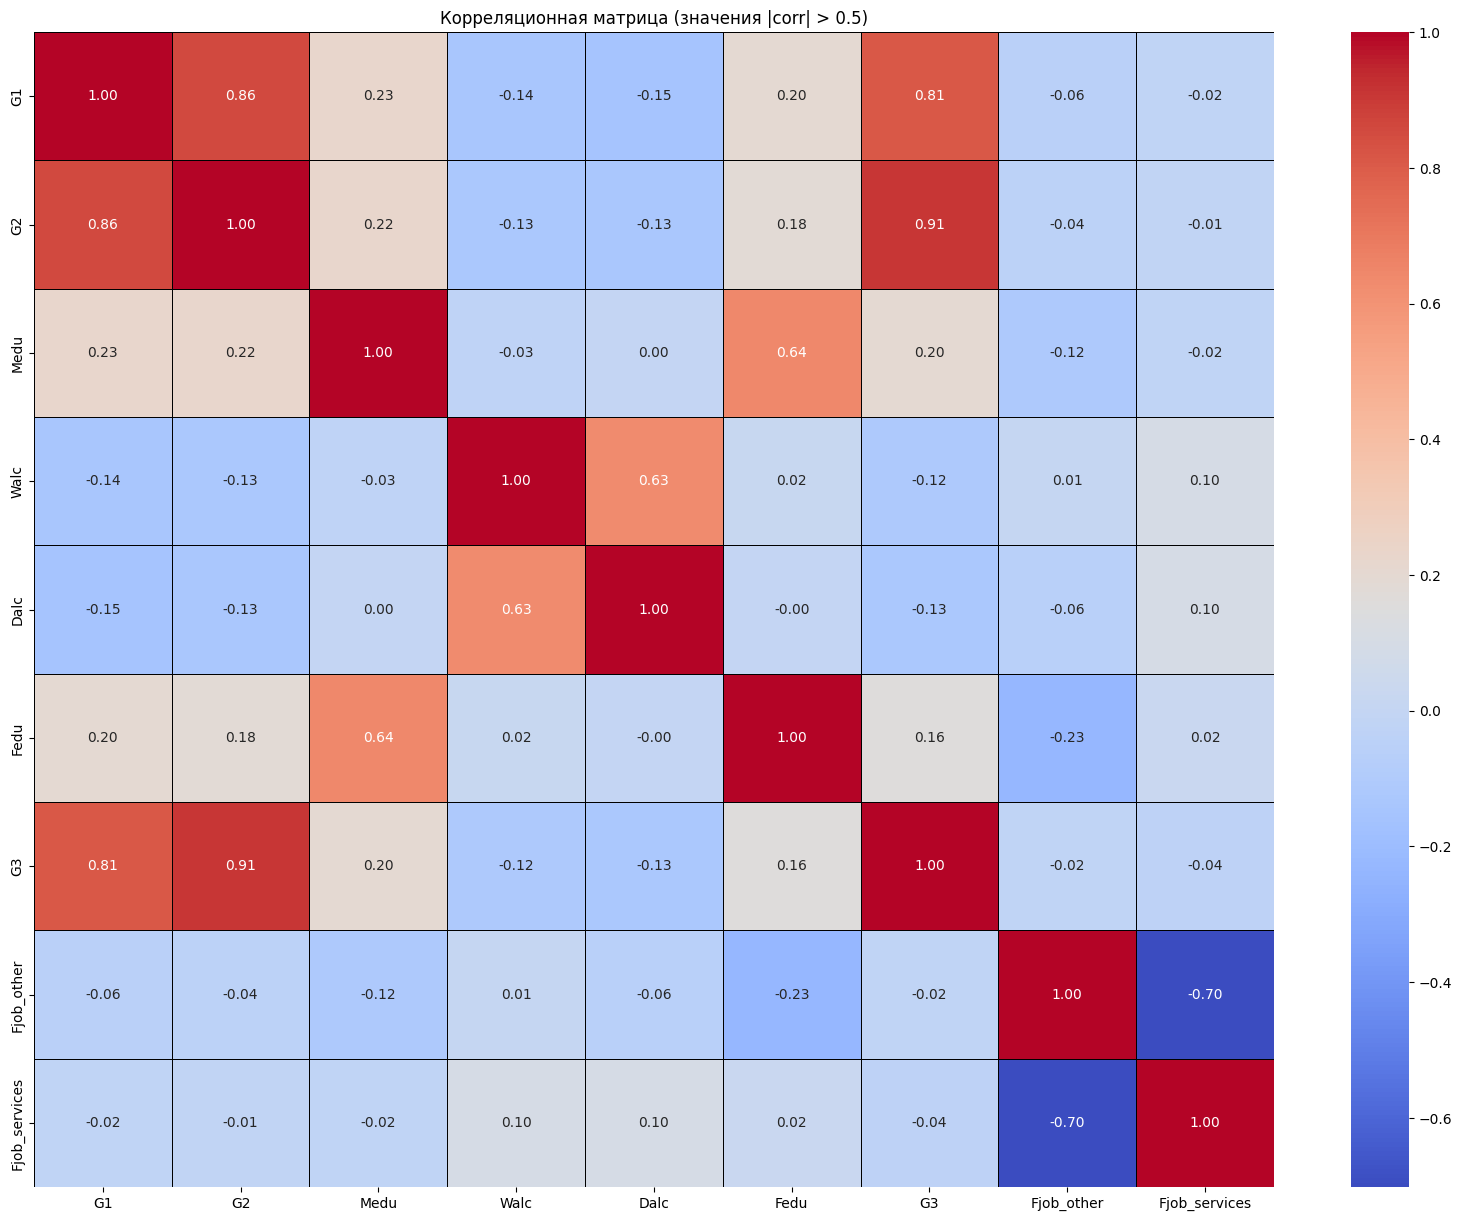

In [1351]:
cor_with_threshold(corr, 0.5)

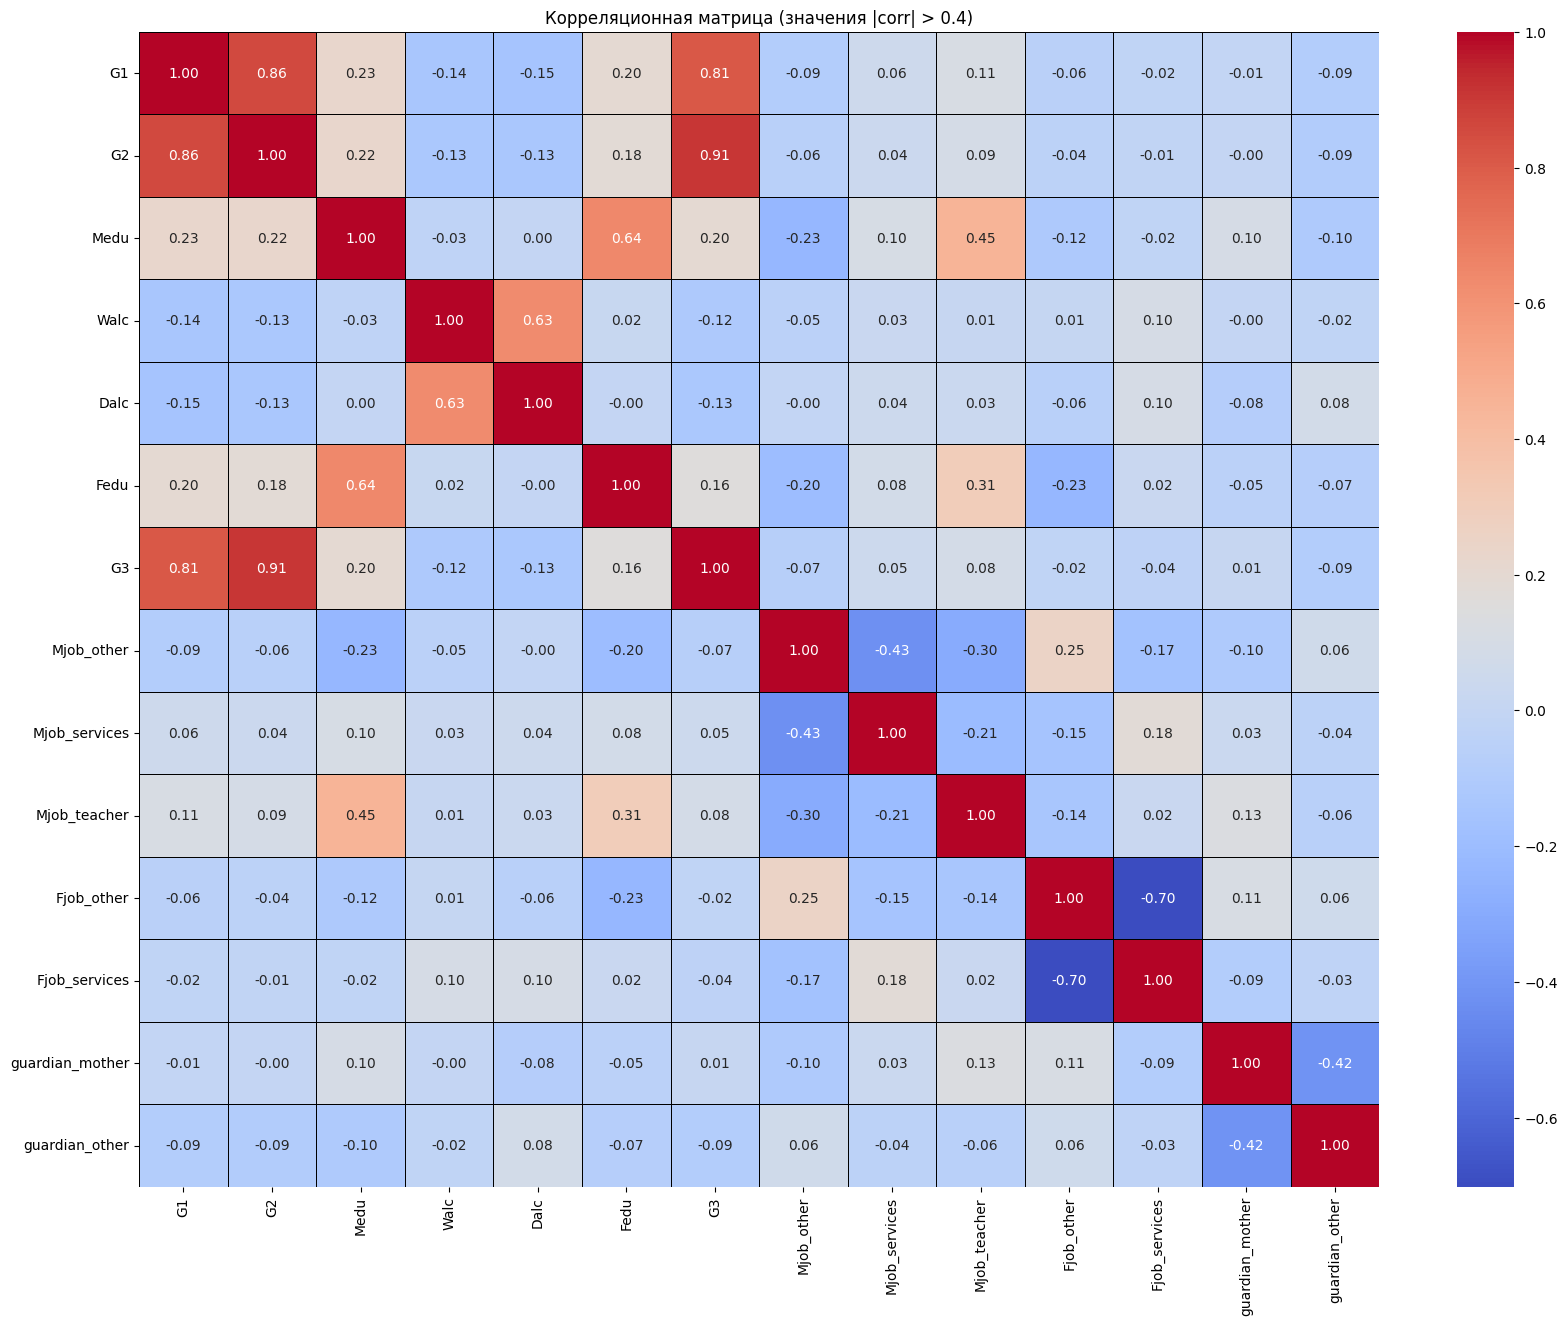

In [1352]:
cor_with_threshold(corr, 0.4)

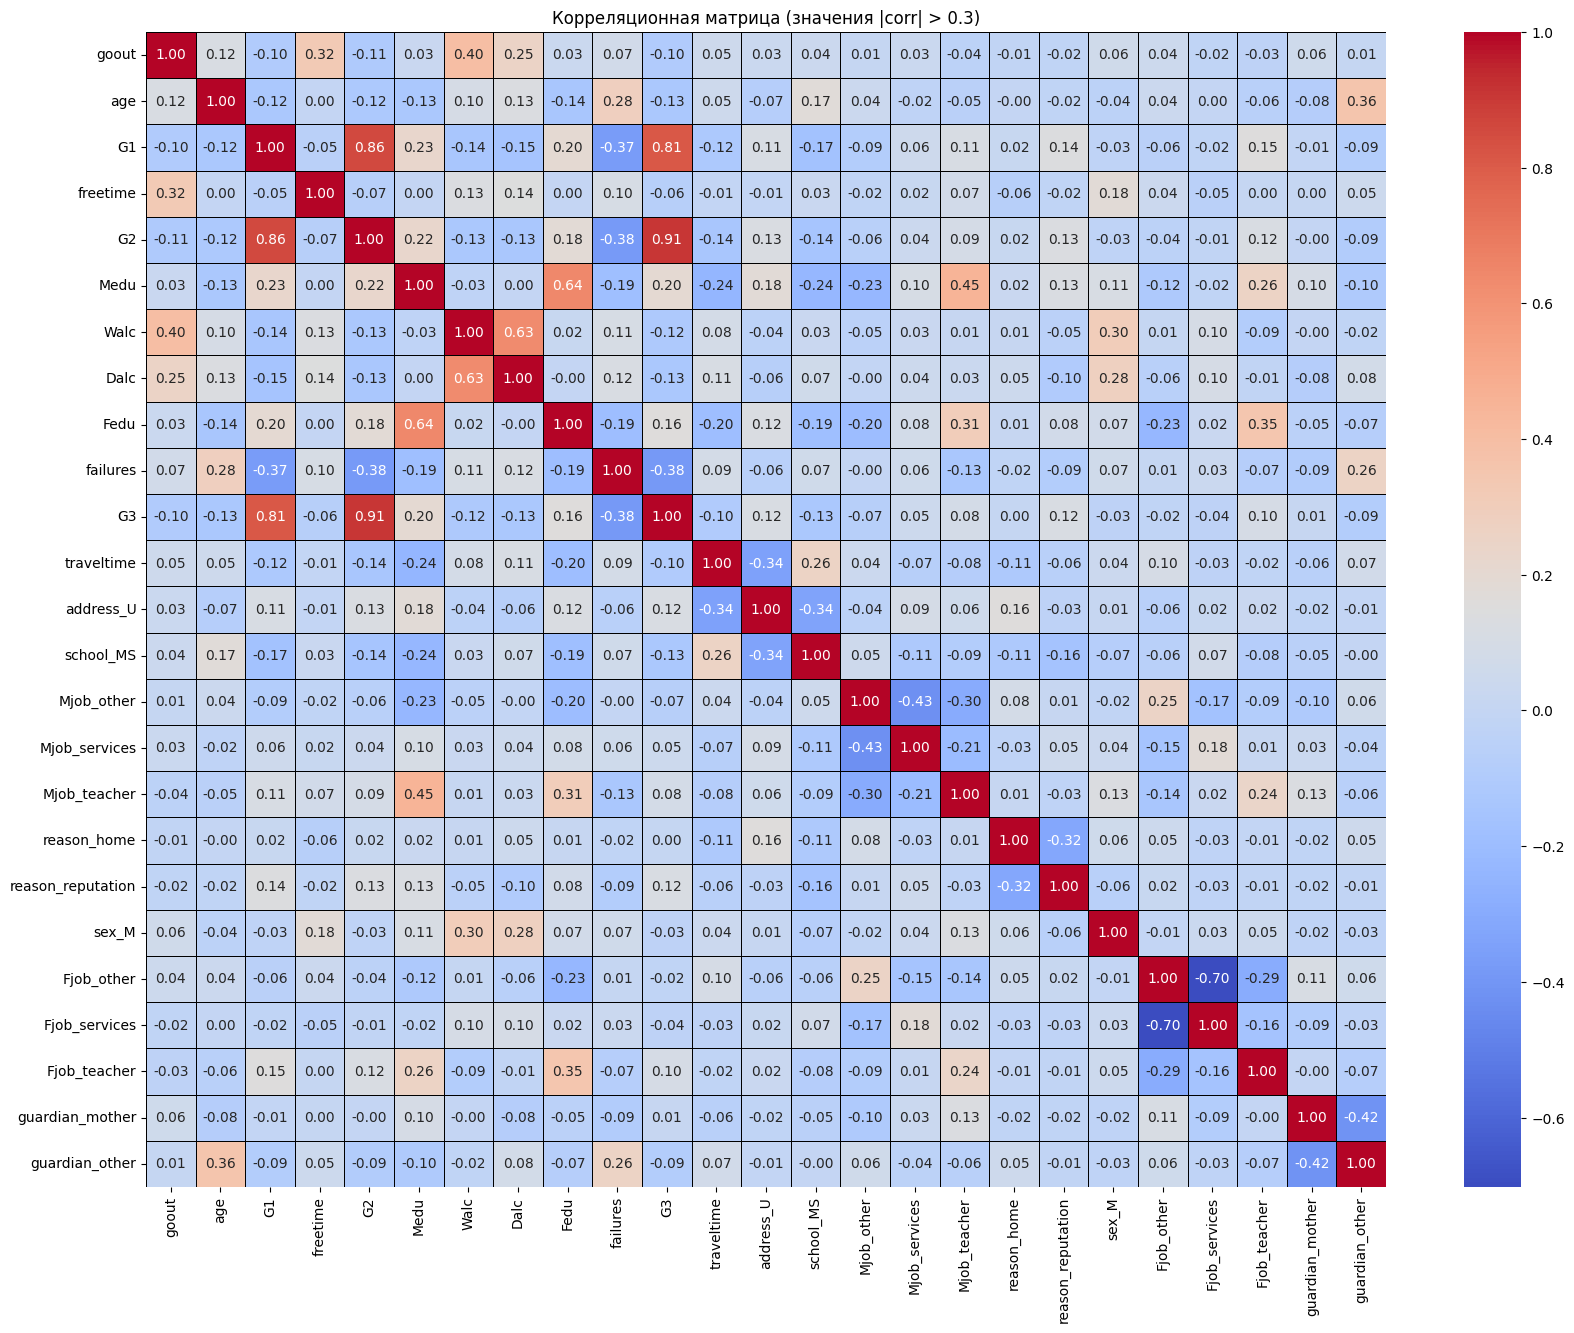

In [1353]:
cor_with_threshold(corr, 0.3)

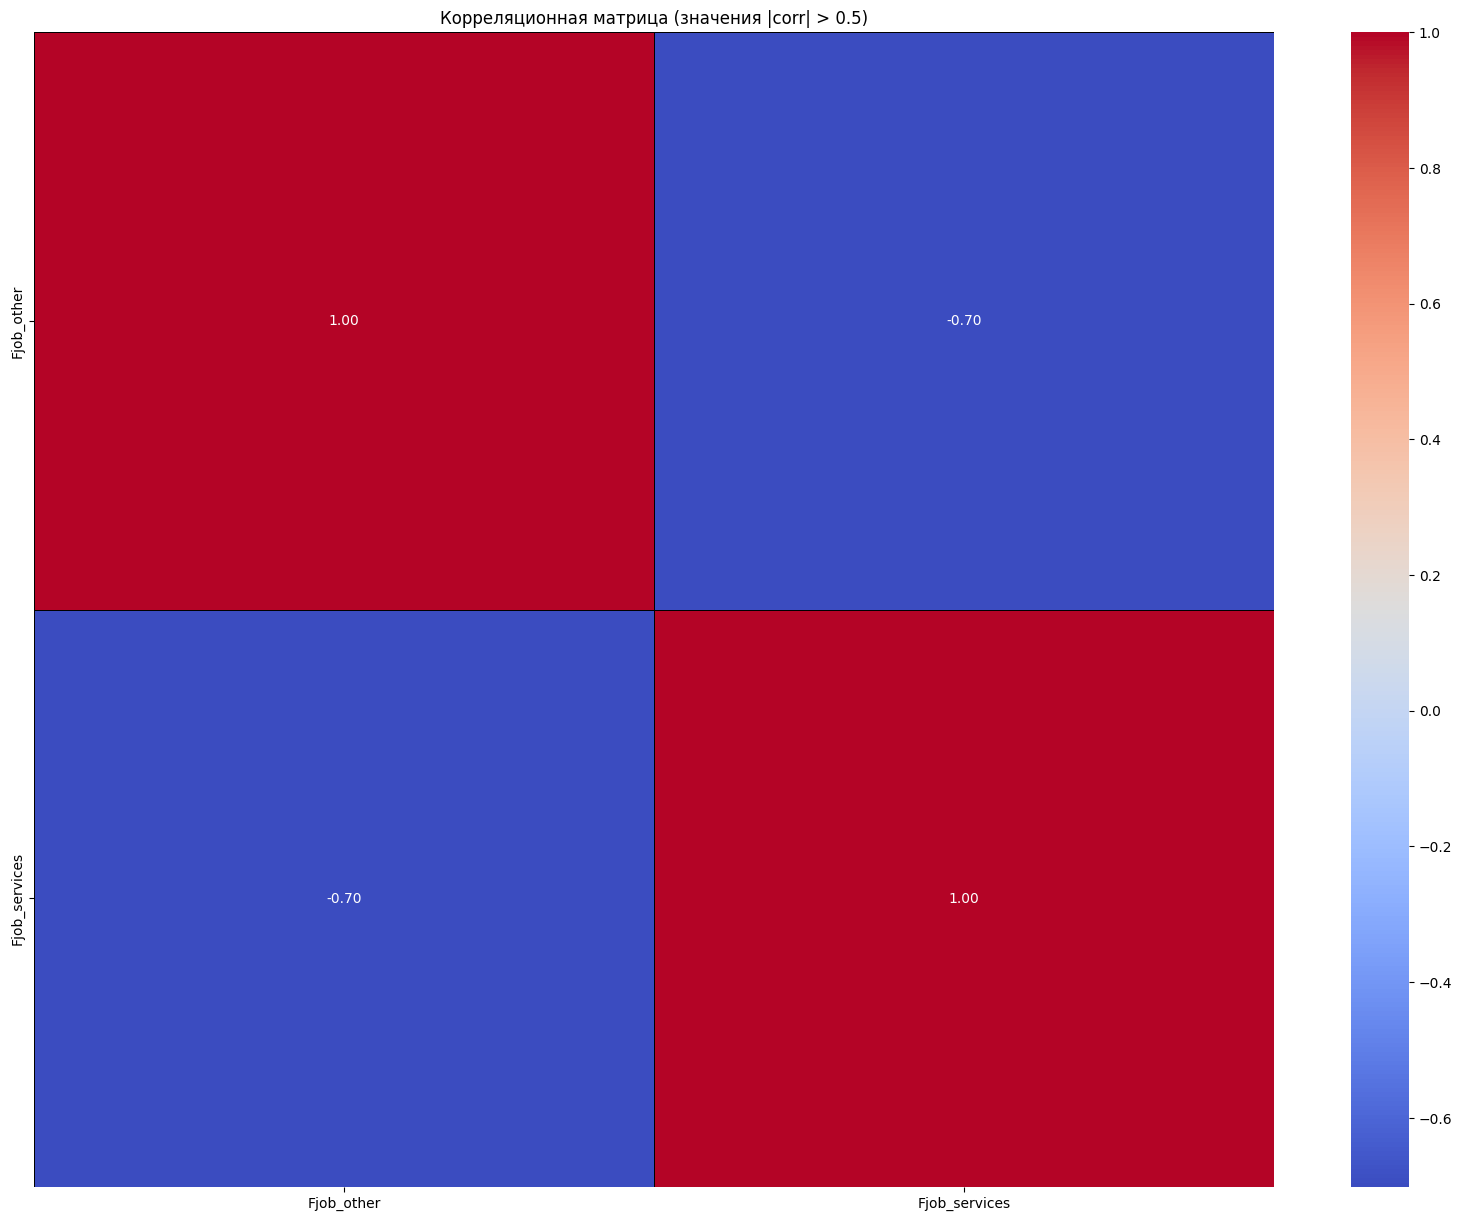

In [1354]:
# Создание новых признаков
data_encoded_eda['average_grade'] = data_encoded_eda[['G1', 'G2', 'G3']].mean(axis=1)
data_encoded_eda['total_alcohol'] = data_encoded_eda['Dalc'] + data_encoded_eda['Walc']
data_encoded_eda['parent_education'] = data_encoded_eda['Medu'] + data_encoded_eda['Fedu']

features = data_encoded_eda.drop(['G1', 'G2', 'G3', 'Dalc', 'Walc', 'Medu', 'Fedu'], axis=1)

corr = features.corr()

cor_with_threshold(corr, 0.5)

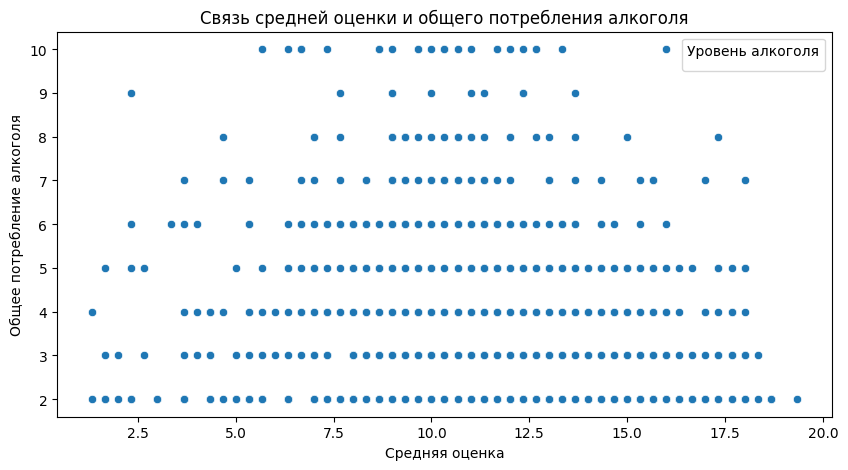

In [1355]:
# Взаимосвязь потребления алкоголя с оценками

plt.figure(figsize=(10,5))
sns.scatterplot(x='average_grade', y='total_alcohol', data=features, palette='viridis')
plt.title('Связь средней оценки и общего потребления алкоголя')
plt.xlabel('Средняя оценка')
plt.ylabel('Общее потребление алкоголя')
plt.legend(title='Уровень алкоголя')
plt.show()

Переведя катигориальные признаки в бинарные и построив матрицу кореляции мы приходи к следющим выводам:
Общие закономерности:

* Сильная взаимосвязь между оценками студентов

    - G3 (финальная оценка) и G1, G2 (оценки за первые два периода):
        - Корреляция между G3 и G2: 0.91
        - Корреляция между G3 и G1: 0.81
        - Корреляция между G1 и G2: 0.86

    Существует высокая положительная корреляция между финальной оценкой студентов (G3) и их оценками за первые два периода (G1 и G2). Это указывает на то, что успеваемость студентов в начале учебного года сильно влияет на их итоговые оценки. Студенты, показывающие хорошие результаты на ранних этапах обучения, вероятно, сохранят высокий уровень успеваемости до конца года.

* Взаимосвязь уровня образования родителей

    - Medu (образование матери) и Fedu (образование отца): 0.64

    Значительная положительная корреляция между образованием матери и отца указывает на то, что родители студентов обычно имеют сопоставимый уровень образования. Это может свидетельствовать о том, что семейный фон играет важную роль в уровне образования, который достигают дети.

* Связь дневного и вечернего потребления алкоголя

    - Walc (вечернее потребление алкоголя) и Dalc (дневное потребление алкоголя): 0.63

    Умеренная положительная корреляция между дневным и вечерним потреблением алкоголя указывает на то, что студенты, которые употребляют алкоголь в течение дня, склонны также употреблять его вечером. Это может свидетельствовать о регулярных привычках потребления алкоголя или о том, что учащиеся, склонные к употреблению алкоголя, делают это как в дневное, так и в вечернее время.

* Отрицательная корреляция между типами занятости

    - Fjob_other (занятость в других секторах) и Fjob_services (занятость в сфере услуг): -0.70

    Сильная отрицательная корреляция между занятостью в других секторах и занятостью в сфере услуг указывает на то, что студенты, работающие в одном из этих секторов, редко одновременно работают в другом. Это может быть связано с тем, что различные сектора имеют разные требования и условия труда, что делает одновременную работу в обоих секторах маловероятной.

* Низкая взаимосвязь большинства признаков: Большинство остальных корреляций в матрице ниже порога 0.3, что свидетельствует о слабых или отсутствующих прямых линейных связях между ними. Это может указывать на то, что уровень потребления алкоголя студентами зависит от множества факторов, и для его прогнозирования потребуется учитывать комплексные взаимодействия между признаками или использовать нелинейные модели.

* Отсутствие сильной корреляции между уровнем образования родителей и успеваемостью: Хотя образование родителей (Medu и Fedu) коррелирует с общим уровнем образования в семье, прямой сильной связи между образованием родителей и оценками студентов (G1, G2, G3) не наблюдается. Это может означать, что другие факторы, такие как личная мотивация, школьные условия или социальная среда, играют более значимую роль в успеваемости студентов.
* В школе  Mousinho da Silveira учаться люди старше
* Кто часто пьёт на недле, пьёт и в выходные
Закономерности относительно целевой метрики
* Успеваемость обратно пропоциональна "failures", однако из описания датасета не совсем понятно, что значит эта переменная(я перевёл это как пересдачи, но не понятно почему они начинаются с 1)
* Успеваемость в семестрах прямопорциональна оценке за экзамен



Объяснение того, какие признаки нужно удалить

- averate_grade ~ G1, G2, G3
- total_alcohol ~ Dalc и Walc
- failures ~ -average_grade
- traveltime ~ -address_U
- Fjob_other ~ -Fjob_services
- Mjob_other ~ -Mjob_services
!!!!нужно подумать - guardian_other ~ -guardian_M


In [1356]:
features = features.drop(['failures', 'address_U', 'Fjob_other', 'Mjob_other', 'guardian_other'], axis=1)

# Проверка формы данных
print(f"Количество признаков после выбора: {features.shape[1]}")
print(features.columns)

Количество признаков после выбора: 33
Index(['goout', 'age', 'freetime', 'absences', 'studytime', 'famrel', 'health',
       'traveltime', 'higher_yes', 'romantic_yes', 'activities_yes',
       'school_MS', 'nursery_yes', 'Mjob_health', 'Mjob_services',
       'Mjob_teacher', 'reason_home', 'reason_other', 'reason_reputation',
       'sex_M', 'famsize_LE3', 'Pstatus_T', 'paid_yes', 'Fjob_health',
       'Fjob_services', 'Fjob_teacher', 'schoolsup_yes', 'famsup_yes',
       'guardian_mother', 'internet_yes', 'average_grade', 'total_alcohol',
       'parent_education'],
      dtype='object')


In [1357]:
# Масштабирование числовых признаков
numerical_features = features.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
features[numerical_features] = scaler.fit_transform(features[numerical_features])

# Проверка масштабирования
features.head()

,goout,age,freetime,absences,studytime,famrel,health,traveltime,higher_yes,romantic_yes,...,Fjob_health,Fjob_services,Fjob_teacher,schoolsup_yes,famsup_yes,guardian_mother,internet_yes,average_grade,total_alcohol,parent_education
0,0.732511,1.027889,-0.195099,0.252155,0.035606,0.068788,-0.381387,0.652210,True,False,...,False,False,True,True,False,True,False,-1.740788,-0.894969,1.493104
1,-0.135527,0.221035,-0.195099,-0.070060,0.035606,1.140653,-0.381387,-0.715074,True,False,...,False,False,False,False,True,False,True,-1.844396,-0.894969,-1.484547
2,-1.003566,-1.392674,-0.195099,0.896584,0.035606,0.068788,-0.381387,-0.715074,True,False,...,False,False,False,True,False,True,True,-0.911927,0.614478,-1.484547
3,-1.003566,-1.392674,-1.165019,-0.392275,1.234713,-1.003076,1.023086,-0.715074,True,True,...,False,True,False,False,True,True,True,1.056620,-0.894969,0.500553
4,-1.003566,-0.585820,-0.195099,-0.070060,0.035606,0.068788,1.023086,-0.715074,True,False,...,False,False,False,False,True,False,False,-0.808319,-0.391820,0.500553


In [1358]:
# Вычисление корреляции признаков с целевой переменной
corr_with_target = features.corr()['total_alcohol'].abs().sort_values(ascending=False)

# Выбор признаков с корреляцией > 0.05
selected_features = corr_with_target[corr_with_target > 0.05].index.tolist() # Если не удалять некоррелирующие признаки, то R2 будет ещё больше

print("Признаки, выбранные на основе корреляции с целевой переменной:")
print(selected_features)

selected_features.remove('total_alcohol')

features_encoded_filtered = features[selected_features]

print(f"Количество признаков после фильтрации: {features_encoded_filtered.shape[1]}")


Признаки, выбранные на основе корреляции с целевой переменной:
['total_alcohol', 'goout', 'sex_M', 'studytime', 'average_grade', 'absences', 'freetime', 'age', 'higher_yes', 'Fjob_services', 'reason_other', 'traveltime', 'famrel', 'health', 'famsize_LE3', 'nursery_yes', 'reason_reputation', 'schoolsup_yes', 'Fjob_teacher', 'famsup_yes']
Количество признаков после фильтрации: 19


Последний раз убедимся, что сильно коррелируемых прихнаков нет

In [1359]:
# corr = features_encoded_filtered.corr()

# cor_with_threshold(corr, 0)

Создание полиномиальных признаков, потому что изначально модели объясняли лишь небольшую часть вариации целевой переменной total_alcohol (R^2 около 0.27-0.34)

In [1360]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly_features = poly.fit_transform(features_encoded_filtered)
poly_feature_names = poly.get_feature_names_out(features_encoded_filtered.columns)
features_poly = pd.DataFrame(poly_features, columns=poly_feature_names)

# Маштабирование полиномиальных признаков
numerical_features_poly = features_poly.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
features_poly[numerical_features_poly] = scaler.fit_transform(features_poly[numerical_features_poly])

features_poly.columns = [col.replace(' ', '-') for col in features_poly.columns]

In [1361]:
# Определение целевой переменной
target = features['total_alcohol']

features = features_poly

Выделение важных признаков

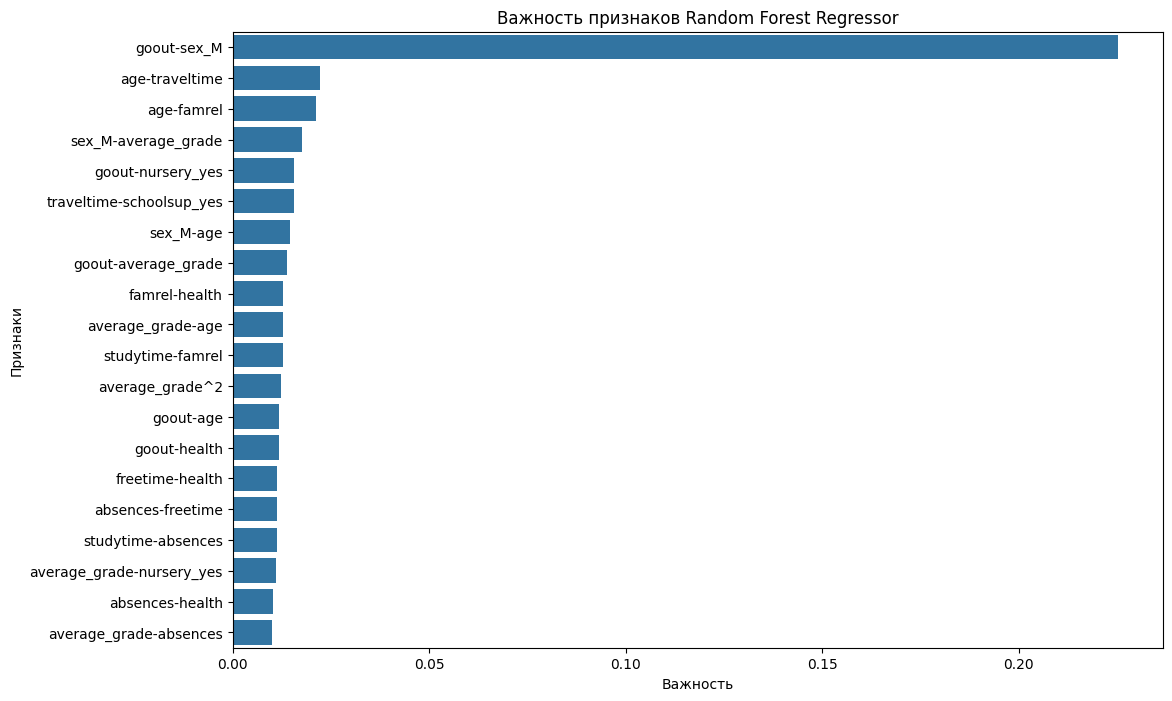

Index(['goout', 'sex_M', 'studytime', 'average_grade', 'absences', 'freetime',
       'age', 'higher_yes', 'Fjob_services', 'reason_other',
       ...
       'reason_reputation^2', 'reason_reputation-schoolsup_yes',
       'reason_reputation-Fjob_teacher', 'reason_reputation-famsup_yes',
       'schoolsup_yes^2', 'schoolsup_yes-Fjob_teacher',
       'schoolsup_yes-famsup_yes', 'Fjob_teacher^2', 'Fjob_teacher-famsup_yes',
       'famsup_yes^2'],
      dtype='object', length=209)


In [1362]:
rf = RandomForestRegressor(random_state=42)

# Гиперпараметры для Grid Search
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search с кросс-валидацией
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(features, target)

best_rf = grid_rf.best_estimator_

importances = best_rf.feature_importances_
feature_names = features.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x=feature_importances[:20], y=feature_importances.index[:20])
plt.title('Важность признаков Random Forest Regressor')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

threshold = 0.01
important_features = feature_importances[feature_importances > threshold].index
# features = features[important_features]
print(features.columns)

Уменьшение количества признаков до только важных ещё сильнее уменьшило R^2

In [1363]:
# Разделение данных: 80% для обучения, 20% для тестирования
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
# print(y_test)
print(X_train.columns)

Размер обучающей выборки: (835, 209)
Размер тестовой выборки: (209, 209)
Index(['goout', 'sex_M', 'studytime', 'average_grade', 'absences', 'freetime',
       'age', 'higher_yes', 'Fjob_services', 'reason_other',
       ...
       'reason_reputation^2', 'reason_reputation-schoolsup_yes',
       'reason_reputation-Fjob_teacher', 'reason_reputation-famsup_yes',
       'schoolsup_yes^2', 'schoolsup_yes-Fjob_teacher',
       'schoolsup_yes-famsup_yes', 'Fjob_teacher^2', 'Fjob_teacher-famsup_yes',
       'famsup_yes^2'],
      dtype='object', length=209)


## Построение моделей МО

Классификация. Random Forest

In [1364]:
rf = RandomForestRegressor(random_state=42)

# Гиперпараметры для Grid Search
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search с кросс-валидацией
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print(f"Лучшие параметры Random Forest Regressor: {grid_rf.best_params_}")


Лучшие параметры Random Forest Regressor: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [1365]:
# Оценка модели на тестовой выборке
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Random Forest Regressor - Оценка модели:")
print(f"Среднеквадратичная ошибка (MSE): {mean_squared_error(y_test, y_pred_rf):.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"Коэффициент детерминации (R²): {r2_score(y_test, y_pred_rf):.2f}")

Random Forest Regressor - Оценка модели:
Среднеквадратичная ошибка (MSE): 0.63
Средняя абсолютная ошибка (MAE): 0.59
Коэффициент детерминации (R²): 0.38


XGBoost

In [1366]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

# Гиперпараметры для Grid Search
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1]
}

# Grid Search с кросс-валидацией
grid_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print(f"Лучшие параметры XGBoost Regressor: {grid_xgb.best_params_}")

Лучшие параметры XGBoost Regressor: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.7}


In [1367]:
# Оценка модели XGBoost Regressor на тестовой выборке
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("XGBoost Regressor - Оценка модели:")
print(f"Среднеквадратичная ошибка (MSE): {mean_squared_error(y_test, y_pred_xgb):.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mean_absolute_error(y_test, y_pred_xgb):.2f}")
print(f"Коэффициент детерминации (R²): {r2_score(y_test, y_pred_xgb):.2f}")

XGBoost Regressor - Оценка модели:
Среднеквадратичная ошибка (MSE): 0.57
Средняя абсолютная ошибка (MAE): 0.54
Коэффициент детерминации (R²): 0.43


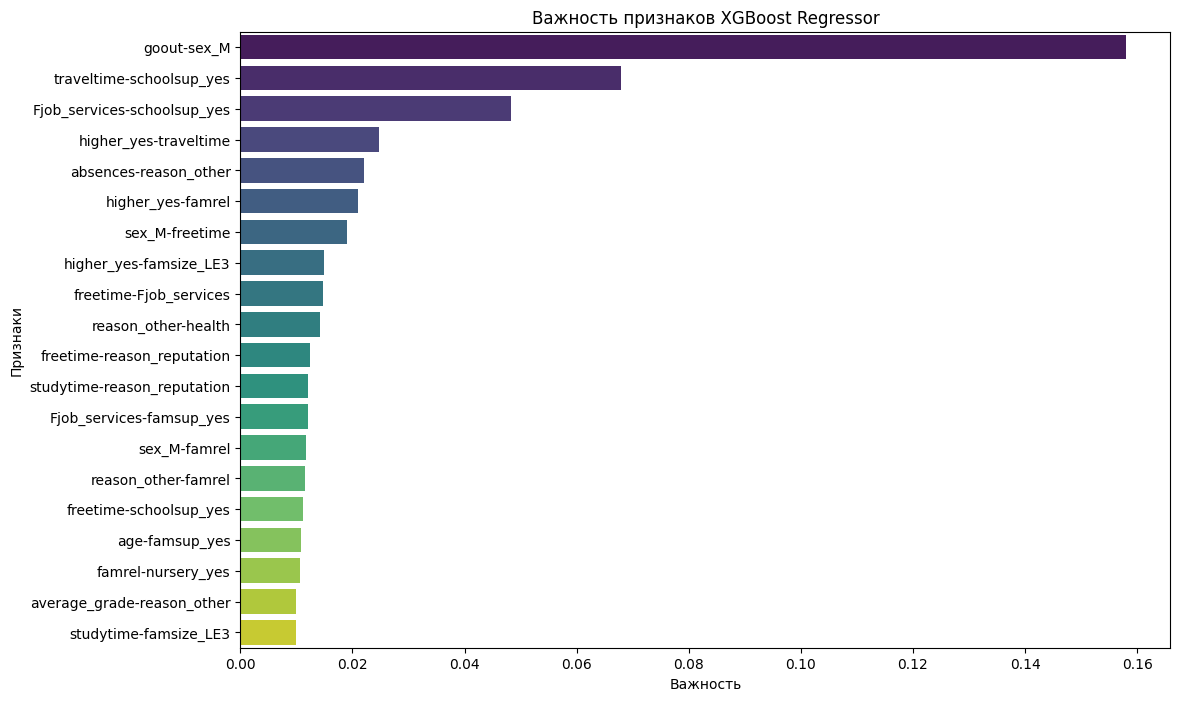

In [1368]:
# Важность признаков для XGBoost Regressor
importances_xgb = best_xgb.feature_importances_
feature_names_xgb = features.columns
feature_importances_xgb = pd.Series(importances_xgb, index=feature_names_xgb).sort_values(ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x=feature_importances_xgb[:20], y=feature_importances_xgb.index[:20], palette='viridis')
plt.title('Важность признаков XGBoost Regressor')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

In [1369]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(random_state=42, max_iter=2000, solver='adam', learning_rate_init=0.001, early_stopping=True, validation_fraction=0.1)

# Гиперпараметры для Grid Search
param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (100, 50), (50, 50, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant','adaptive'],
}

# Grid Search с кросс-валидацией
grid_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_mlp.fit(X_train, y_train)

print(f"Лучшие параметры MLP Regressor: {grid_mlp.best_params_}")

Лучшие параметры MLP Regressor: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [1370]:
# Оценка модели MLP Regressor на тестовой выборке
best_mlp = grid_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test)

print("MLP Regressor - Оценка модели:")
print(f"Среднеквадратичная ошибка (MSE): {mean_squared_error(y_test, y_pred_mlp):.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mean_absolute_error(y_test, y_pred_mlp):.2f}")
print(f"Коэффициент детерминации (R²): {r2_score(y_test, y_pred_mlp):.2f}")

MLP Regressor - Оценка модели:
Среднеквадратичная ошибка (MSE): 0.72
Средняя абсолютная ошибка (MAE): 0.58
Коэффициент детерминации (R²): 0.28


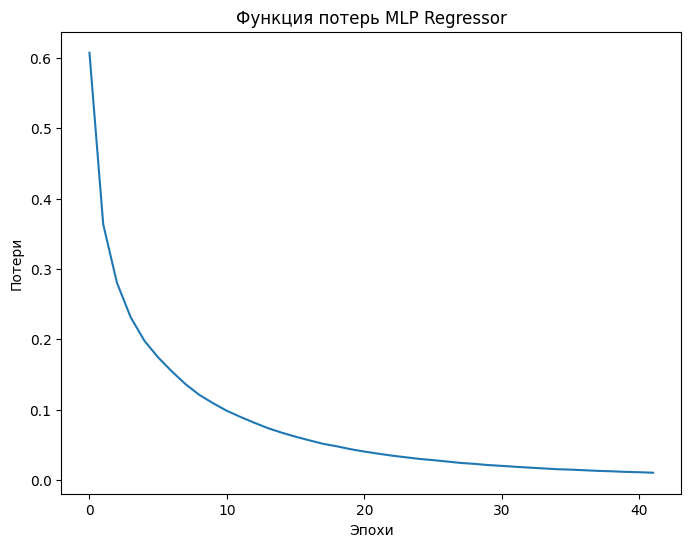

In [1371]:
if hasattr(best_mlp, 'loss_curve_'):
    plt.figure(figsize=(8,6))
    plt.plot(best_mlp.loss_curve_)
    plt.title('Функция потерь MLP Regressor')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.show()
else:
    print("Модель MLP Regressor не сохранила историю потерь.")


In [1372]:
# import lightgbm as lgb

# lgb_reg = lgb.LGBMRegressor(random_state=42)

# param_grid_lgb = {
#     'n_estimators': [100, 200],
#     'max_depth': [5, 10, 15],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'num_leaves': [31, 50, 100]
# }

# grid_lgb = GridSearchCV(estimator=lgb_reg, param_grid=param_grid_lgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_lgb.fit(X_train, y_train)

# print(f"Лучшие параметры LightGBM Regressor: {grid_lgb.best_params_}")

# best_lgb = grid_lgb.best_estimator_
# y_pred_lgb = best_lgb.predict(X_test)

# print("LightGBM Regressor - Оценка модели:")
# print(f"Среднеквадратичная ошибка (MSE): {mean_squared_error(y_test, y_pred_lgb):.2f}")
# print(f"Средняя абсолютная ошибка (MAE): {mean_absolute_error(y_test, y_pred_lgb):.2f}")
# print(f"Коэффициент детерминации (R²): {r2_score(y_test, y_pred_lgb):.2f}")


In [1373]:
from sklearn.svm import SVR

# Support Vector Regressor
svr = SVR()

# Гиперпараметры для Grid Search
param_grid_svr = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Grid Search с кросс-валидацией
grid_svr = GridSearchCV(estimator=svr, param_grid=param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_svr.fit(X_train, y_train)

print(f"Лучшие параметры SVR: {grid_svr.best_params_}")

Лучшие параметры SVR: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [1374]:
# Оценка модели SVR на тестовой выборке
best_svr = grid_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test)

print("SVR - Оценка модели:")
print(f"Среднеквадратичная ошибка (MSE): {mean_squared_error(y_test, y_pred_svr):.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mean_absolute_error(y_test, y_pred_svr):.2f}")
print(f"Коэффициент детерминации (R²): {r2_score(y_test, y_pred_svr):.2f}")


SVR - Оценка модели:
Среднеквадратичная ошибка (MSE): 0.59
Средняя абсолютная ошибка (MAE): 0.52
Коэффициент детерминации (R²): 0.41


In [1375]:
# Ансамбль моделей

from sklearn.ensemble import StackingRegressor

# Определение базовых моделей
estimators = [
    ('rf', best_rf),
    ('mlp', best_mlp),
    ('xgb', best_xgb)
]

# Инициализация Stacking Regressor
stacking_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=xgb.XGBRegressor(),
    cv=5
)

# Обучение Stacking Regressor
stacking_reg.fit(X_train, y_train)

# Предсказание
y_pred_stacking = stacking_reg.predict(X_test)

# Оценка модели
print("Stacking Regressor - Оценка модели:")
print(f"Среднеквадратичная ошибка (MSE): {mean_squared_error(y_test, y_pred_stacking):.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mean_absolute_error(y_test, y_pred_stacking):.2f}")
print(f"Коэффициент детерминации (R²): {r2_score(y_test, y_pred_stacking):.2f}")


Stacking Regressor - Оценка модели:
Среднеквадратичная ошибка (MSE): 0.74
Средняя абсолютная ошибка (MAE): 0.64
Коэффициент детерминации (R²): 0.27


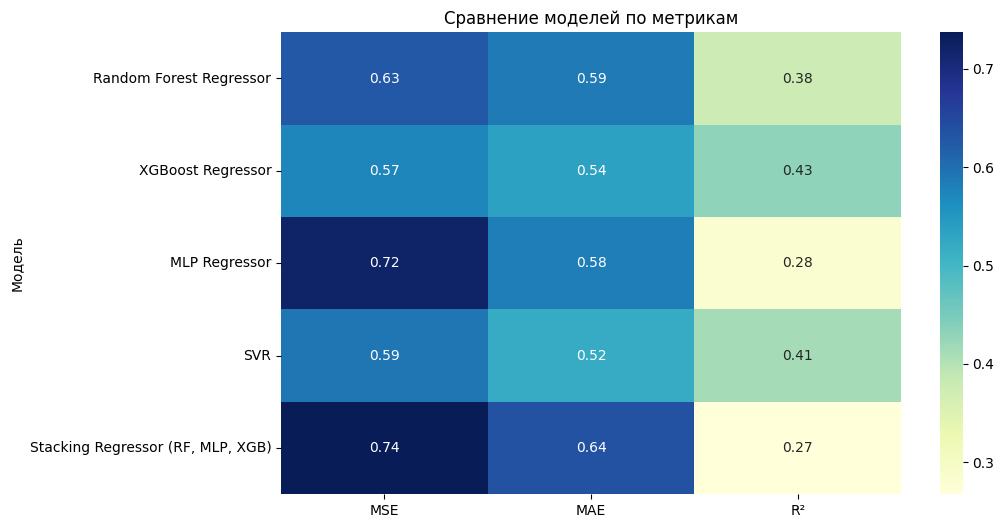

                                        MSE       MAE        R²
Модель                                                         
Random Forest Regressor            0.627325  0.587830  0.376579
XGBoost Regressor                  0.572781  0.535347  0.430783
MLP Regressor                      0.721389  0.581484  0.283099
SVR                                0.590680  0.519499  0.412996
Stacking Regressor (RF, MLP, XGB)  0.737072  0.636082  0.267515


In [1376]:
# Сравнение моделей по основным метрикам

models = ['Random Forest Regressor', 'XGBoost Regressor', 'MLP Regressor', 'SVR', 'Stacking Regressor (RF, MLP, XGB)']
mse = [
    mean_squared_error(y_test, y_pred_rf),
    mean_squared_error(y_test, y_pred_xgb),
    mean_squared_error(y_test, y_pred_mlp),
    mean_squared_error(y_test, y_pred_svr),
    mean_squared_error(y_test, y_pred_stacking)
]
mae = [
    mean_absolute_error(y_test, y_pred_rf),
    mean_absolute_error(y_test, y_pred_xgb),
    mean_absolute_error(y_test, y_pred_mlp),
    mean_absolute_error(y_test, y_pred_svr),
    mean_absolute_error(y_test, y_pred_stacking)
]
r2 = [
    r2_score(y_test, y_pred_rf),
    r2_score(y_test, y_pred_xgb),
    r2_score(y_test, y_pred_mlp),
    r2_score(y_test, y_pred_svr),
    r2_score(y_test, y_pred_stacking)
]

comparison_df = pd.DataFrame({
    'Модель': models,
    'MSE': mse,
    'MAE': mae,
    'R²': r2
})

# Отображение таблицы
plt.figure(figsize=(10,6))
sns.heatmap(comparison_df.set_index('Модель'), annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Сравнение моделей по метрикам')
plt.show()

# Печать таблицы
print(comparison_df.set_index('Модель'))

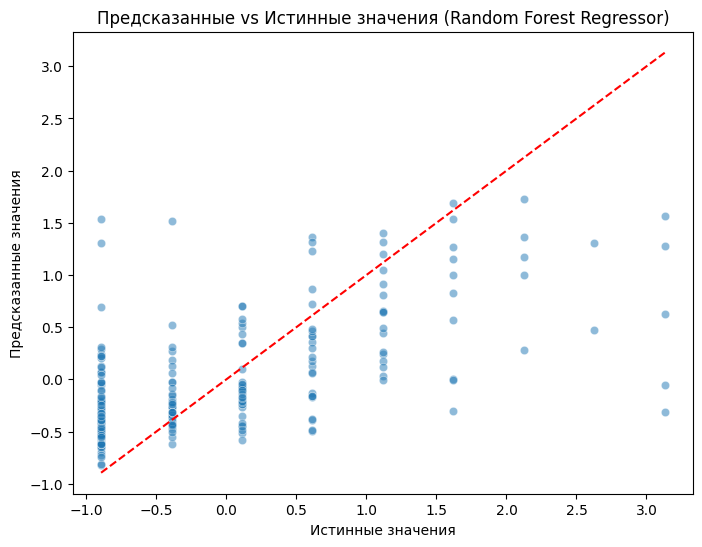

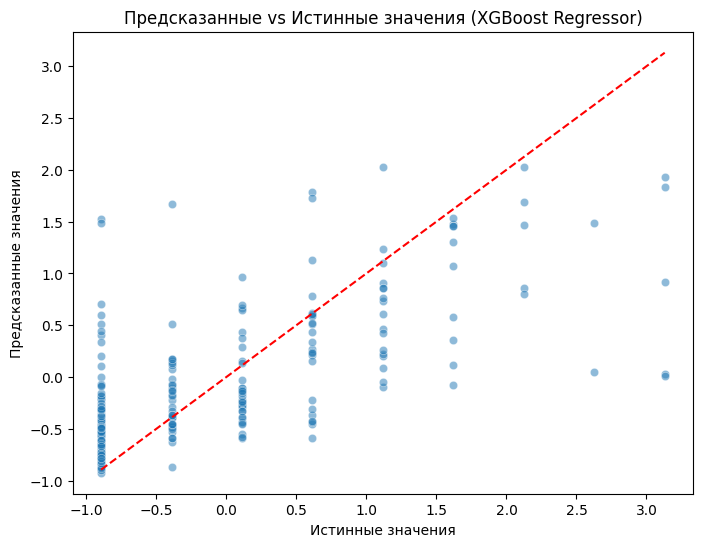

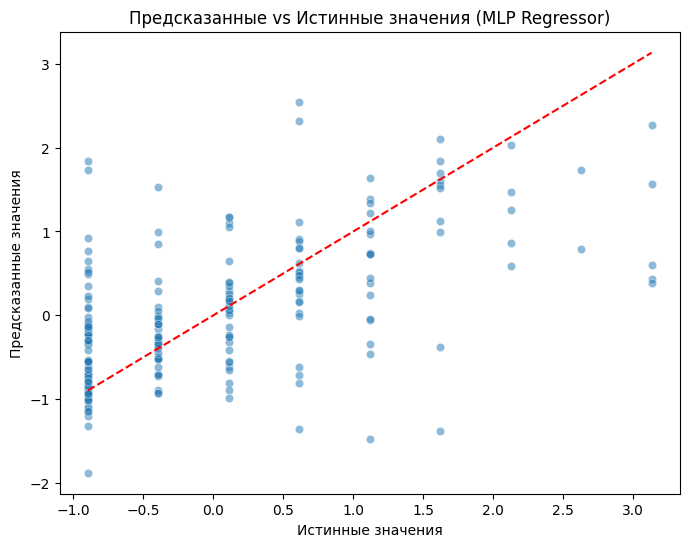

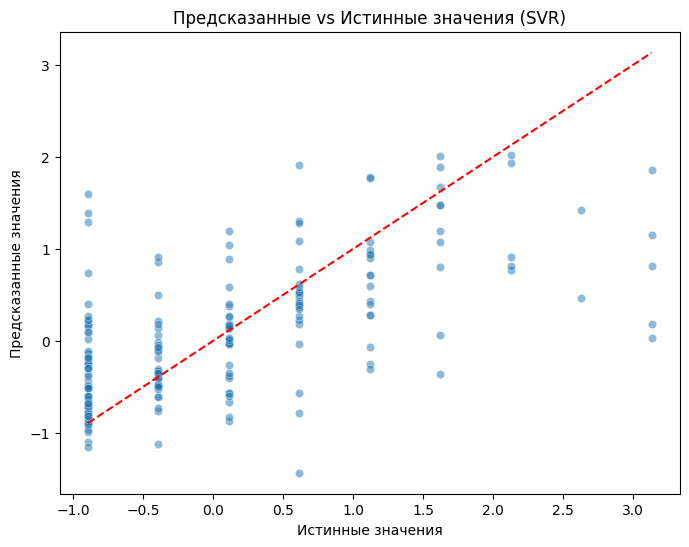

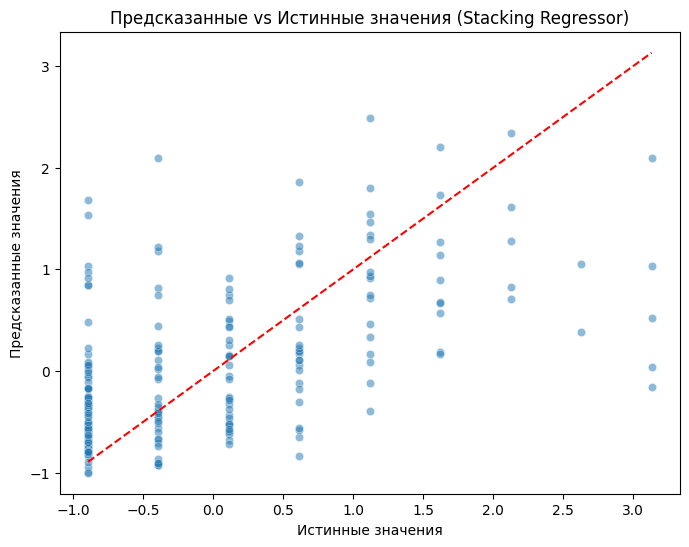

In [1377]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predicted_vs_actual(y_true, y_pred, model_name):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Предсказанные vs Истинные значения ({model_name})')
    plt.show()

plot_predicted_vs_actual(y_test, y_pred_rf, 'Random Forest Regressor')
plot_predicted_vs_actual(y_test, y_pred_xgb, 'XGBoost Regressor')
plot_predicted_vs_actual(y_test, y_pred_mlp, 'MLP Regressor')
plot_predicted_vs_actual(y_test, y_pred_svr, 'SVR')
plot_predicted_vs_actual(y_test, y_pred_stacking, 'Stacking Regressor')


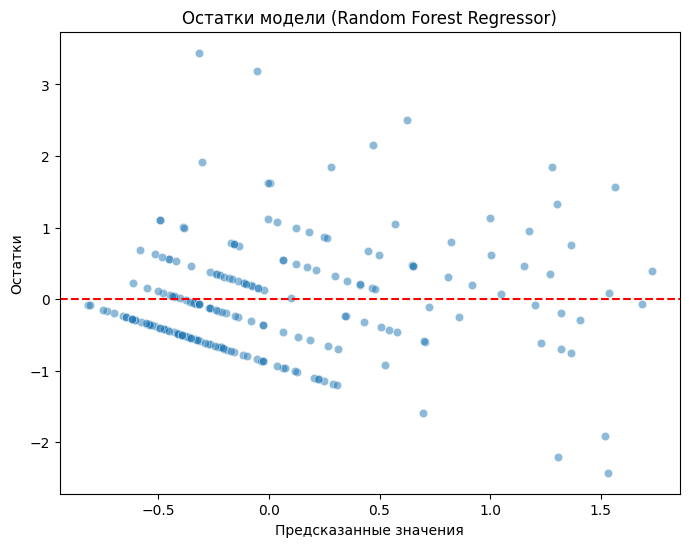

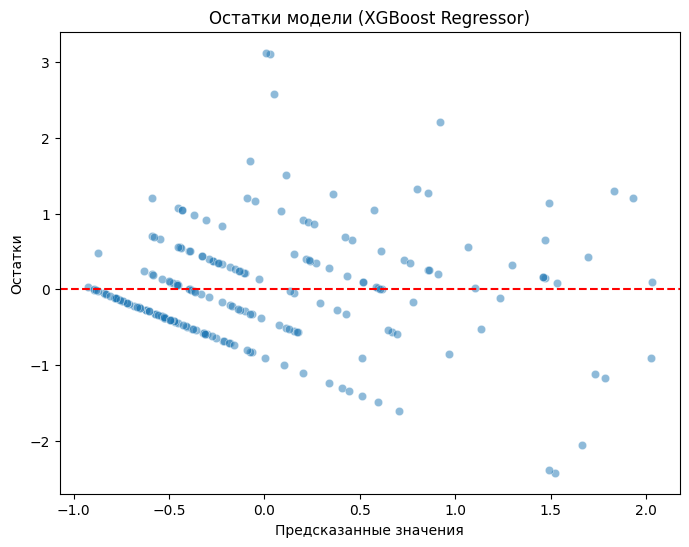

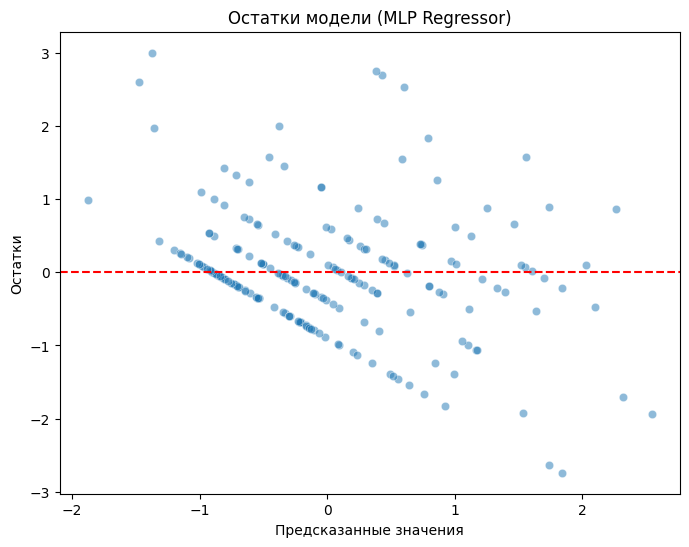

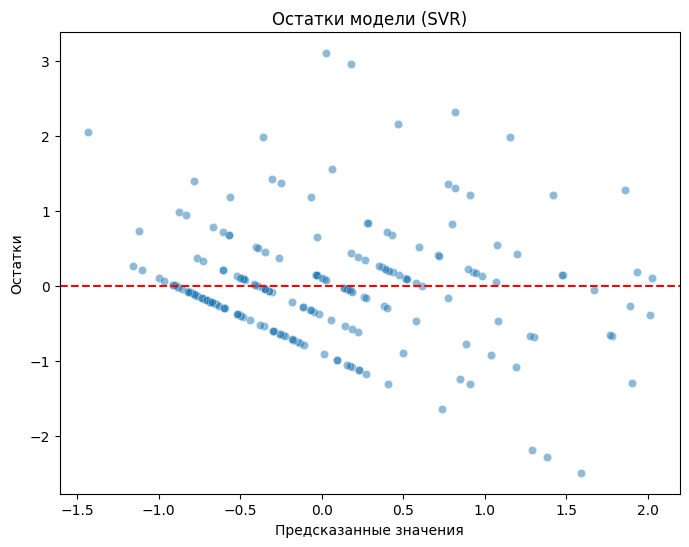

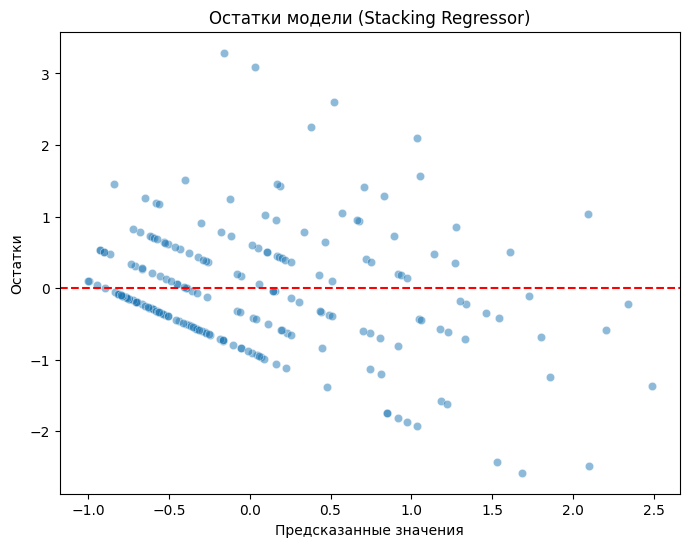

In [1378]:
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')
    plt.title(f'Остатки модели ({model_name})')
    plt.show()

plot_residuals(y_test, y_pred_rf, 'Random Forest Regressor')
plot_residuals(y_test, y_pred_xgb, 'XGBoost Regressor')
plot_residuals(y_test, y_pred_mlp, 'MLP Regressor')
plot_residuals(y_test, y_pred_svr, 'SVR')
plot_residuals(y_test, y_pred_stacking, 'Stacking Regressor')

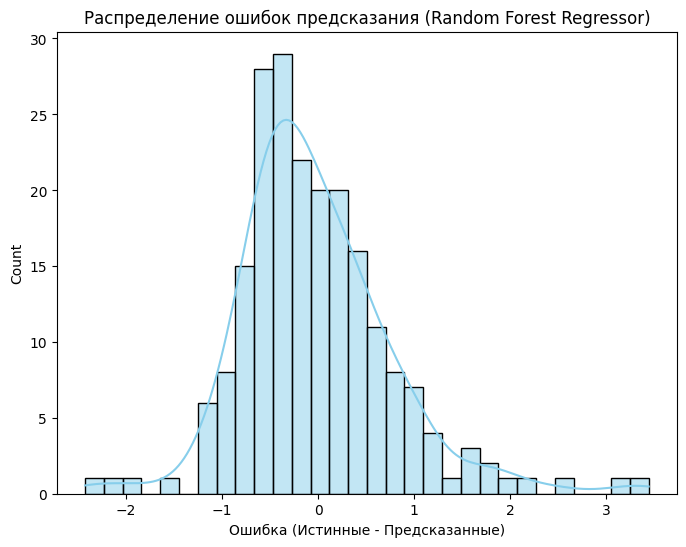

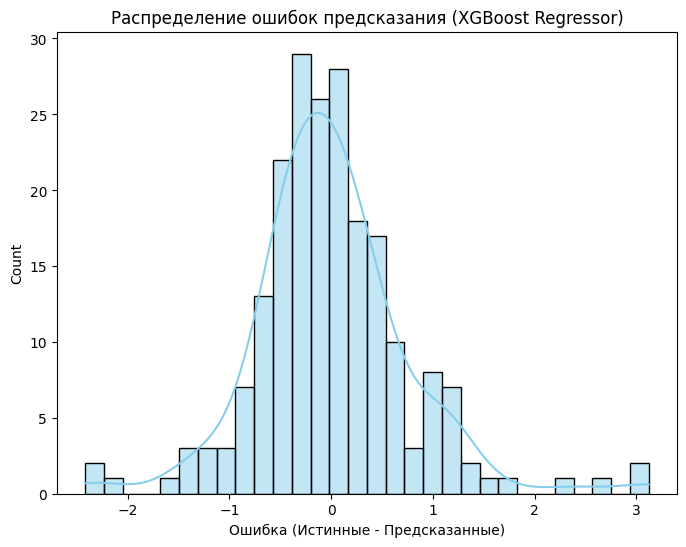

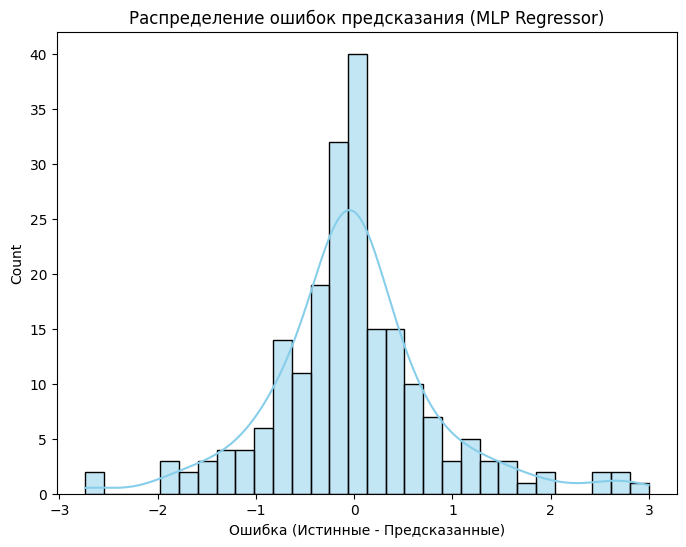

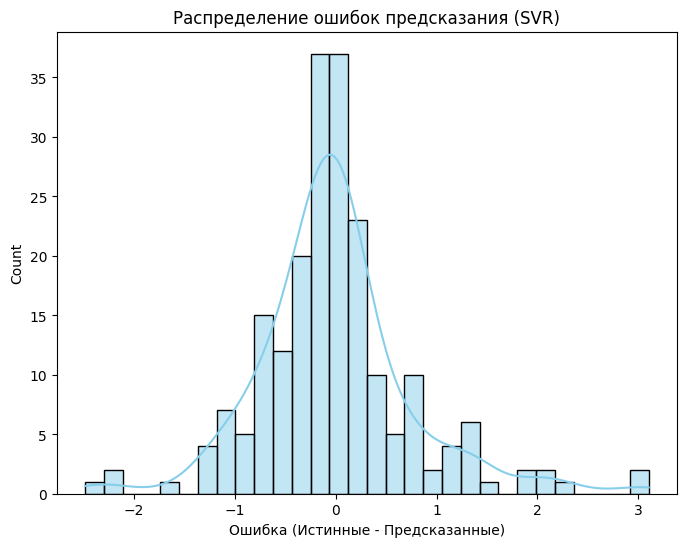

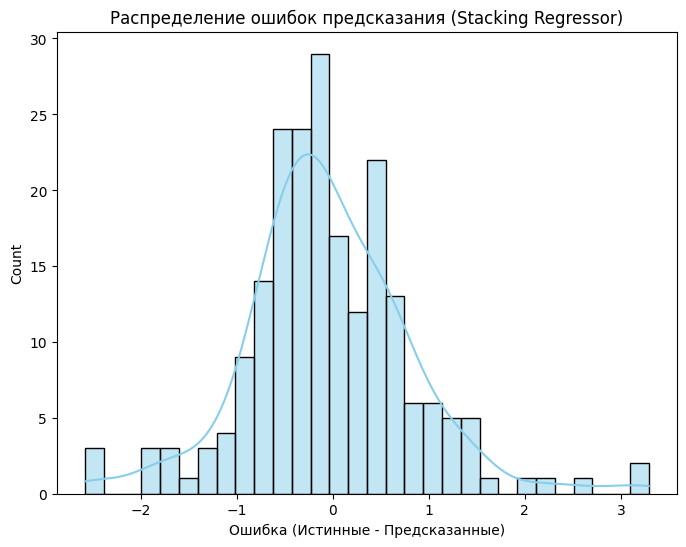

In [1379]:
def plot_error_distribution(y_true, y_pred, model_name):
    errors = y_true - y_pred
    plt.figure(figsize=(8,6))
    sns.histplot(errors, kde=True, bins=30, color='skyblue')
    plt.xlabel('Ошибка (Истинные - Предсказанные)')
    plt.title(f'Распределение ошибок предсказания ({model_name})')
    plt.show()

plot_error_distribution(y_test, y_pred_rf, 'Random Forest Regressor')
plot_error_distribution(y_test, y_pred_xgb, 'XGBoost Regressor')
plot_error_distribution(y_test, y_pred_mlp, 'MLP Regressor')
plot_error_distribution(y_test, y_pred_svr, 'SVR')
plot_error_distribution(y_test, y_pred_stacking, 'Stacking Regressor')


## Кластеризация

In [1380]:
# Используем только числовые признаки для кластеризации
# Исключаем целевую переменную
numerical_features_cluster = features.select_dtypes(include=['int64', 'float64'])

# Масштабирование
scaler_cluster = StandardScaler()
numerical_scaled = scaler_cluster.fit_transform(numerical_features_cluster)

# Метод K-Means++
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans.fit(numerical_scaled)
labels_kmeans = kmeans.labels_

# Оценка качества
silhouette_kmeans = silhouette_score(numerical_scaled, labels_kmeans)
davies_bouldin_kmeans = davies_bouldin_score(numerical_scaled, labels_kmeans)

print(f"K-Means++ Silhouette Score: {silhouette_kmeans:.2f}")
print(f"K-Means++ Davies-Bouldin Index: {davies_bouldin_kmeans:.2f}")


K-Means++ Silhouette Score: 0.04
K-Means++ Davies-Bouldin Index: 5.45


In [1381]:
# Метод DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(numerical_scaled)

# Оценка качества
# Определение количества кластеров (исключая шум)
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
print(f"DBSCAN количество кластеров: {n_clusters_dbscan}")

# Если кластеров больше одного, можно вычислить Silhouette Score
if n_clusters_dbscan > 1:
    silhouette_dbscan = silhouette_score(numerical_scaled, labels_dbscan)
    print(f"DBSCAN Silhouette Score: {silhouette_dbscan:.2f}")
else:
    print("DBSCAN не смог найти более одного кластера.")


DBSCAN количество кластеров: 0
DBSCAN не смог найти более одного кластера.
